# Image Classification using Convolutional Neural Networks - Pytorch

- categories: [deep-learning] 
- image: [images/cnn1.png]

## Exploring the CIFAR10 Dataset

CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

*Link*:- https://www.kaggle.com/c/cifar-10

*Dataset-credentials*:- https://www.cs.toronto.edu/~kriz/cifar.html

![image](https://blog.kickview.com/content/images/size/w2000/2016/12/cfar-1.jpg)

Importing Libraries

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
project_name = 'cifar10-cnn'

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

In [ ]:
# Extract from archive

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:              # r:gz --> read mode in g zip format
    tar.extractall(path='./data')

In [3]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print("No. of test examples for airplanes: ", len(airplane_files))
print(airplane_files[:5])

No. of test examples for airplanes:  5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [5]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No of test examples for ship:", len(ship_test_files))
print(ship_test_files[10:50])

No of test examples for ship: 1000
['0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png']


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [7]:
dataset = ImageFolder(data_dir + '/train', transform = ToTensor())

In [8]:
img, label = dataset[0]
print(img.shape, label)
img[2]                            # img tensor

torch.Size([3, 32, 32]) 0


tensor([[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
        [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
        [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.8078],
        ...,
        [0.8706, 0.8392, 0.7765,  ..., 0.9686, 0.9686, 0.9686],
        [0.8745, 0.8667, 0.8627,  ..., 0.9608, 0.9608, 0.9608],
        [0.8667, 0.8627, 0.8667,  ..., 0.9529, 0.9529, 0.9529]])

In [9]:
# list of classes is stored in .classes property

print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [11]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))                                 # matplot lib expects channels in final dimension
    

Label:  airplane (0)


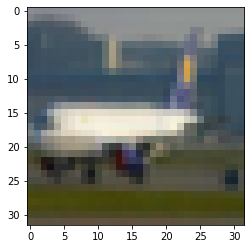

In [12]:
img, label = dataset[5]
show_example(img, label)

Label:  airplane (0)


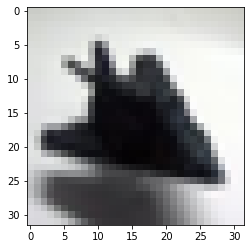

In [13]:
show_example(*dataset[0])

Label:  airplane (0)


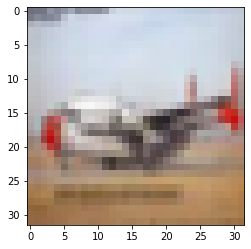

In [14]:
show_example(*dataset[1099])

# Training and Validation Datasets

In [15]:
# To ensure that we always create the same validation set, we'll also set a seed for the random number genertor 

random_seed = 42
torch.manual_seed(random_seed);  # It helps to standardise validation set

In [16]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

## Creating DataLoaders

In [17]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

In [18]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [19]:
# visulize batch images using make_grid method from torchvision

from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

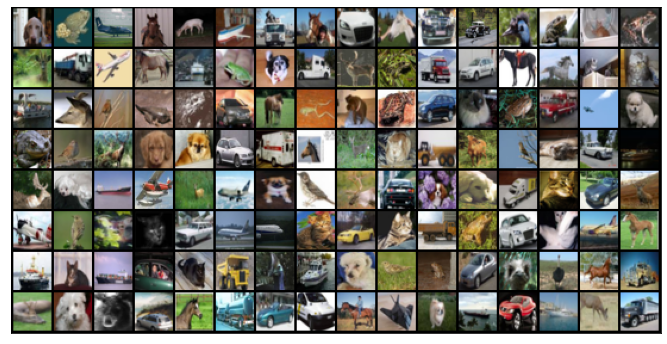

In [20]:
show_batch(train_dl)

# Defining the Conv Model

nn.Linear gives full connected layer architecture 
nn.Conv2d gives convolutional neural network

Basic working of CNN can be described as follows :

![CNN](https://i.stack.imgur.com/HW6xZ.gif)

Working of kernel can be describes as :

![kernel](https://mlnotebook.github.io/img/CNN/convSobel.gif)

Implementation of a convolution operation on a 1 channel image with a 3x3 kernel

In [21]:
def apply_kernel(image, kernel):
    ri, ci = image.shape           #image dimension
    rk, ck = kernel.shape          #kernel dimension
    ro, co = ri-rk+1, ci-ck+1      #output dimension
    output = torch.zeros([ro, co])
    
    for i in range(ro):
        for j in range(co):
            output[i, j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
    return output        
    

In [22]:
# data is take by working of kernel diagram

sample_image = torch.tensor([
    [0, 0, 75, 80, 80],
    [0, 75, 80, 80, 80],
    [0, 75, 80, 80, 80],
    [0, 70, 75, 80, 80],
    [0, 0, 0, 0, 0]
], dtype = torch.float32)


sample_kernel = torch.tensor([
    [-1, -2, -1], 
    [0, 0, 0],
    [1, 2, 1]
], dtype = torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[ 155.,   85.,    5.],
        [ -15.,  -15.,   -5.],
        [-230., -315., -320.]])

## For Multiple channels kernel will have same function over all channels

![multiple_channels](https://miro.medium.com/max/2560/1*ciDgQEjViWLnCbmX-EeSrA.gif)

Refer this blog post for more in-depth intution of CNN :- [Convolution in depth](https://sgugger.github.io/convolution-in-depth.html)

Observation : 5x5 image got reduced to a 3x3 output, while kernel in running over internal values multiple times, but still values of corner are covered only once, so we'll use padding and it will return output as the same size as input

Padding can be understood using following diagram:
![padding](https://m-alcu.github.io/assets/stride1.gif)


Now we have moved kernel by 1 position each time, we can move kernel by 2 positons too, this is call Stride

Stride can be understood using folloeing diagram:
![Stride](https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif)

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

![MAx-pooling](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)


## Applying Single Convolutional Layer followed by max pooling

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
conv = nn.Conv2d(3, 8, kernel_size = 3, stride = 1, padding = 1)    # 8 is no of kernels which also descide no of output channels ie feature map

In [25]:
pool = nn.MaxPool2d(2, 2)

In [26]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = conv(images)
    
    print('output.shape:', out.shape)
    
    out = pool(out)
    
    print('max-pool output.shape:', out.shape)       # max pool will reduce size
    
    break

images.shape: torch.Size([128, 3, 32, 32])
output.shape: torch.Size([128, 8, 32, 32])
max-pool output.shape: torch.Size([128, 8, 16, 16])


In [27]:
# Weights are randomly initilised in kernel and can be checkerd through

conv.weight.shape  # we have 8 kernel and each kernel contain 3 matrices for 3 input channel and each of 3 matrix have 3x3 matrix that is gonna slide 

torch.Size([8, 3, 3, 3])

In [28]:
# one matrix inside 1st kernel

conv.weight[0, 0]

tensor([[-0.1398,  0.1772,  0.0425],
        [-0.0123,  0.1491, -0.0260],
        [ 0.0454,  0.1039,  0.0843]], grad_fn=<SelectBackward>)

In [29]:
# all 3 matrices inside 1st kernel

conv.weight[0]

tensor([[[-0.1398,  0.1772,  0.0425],
         [-0.0123,  0.1491, -0.0260],
         [ 0.0454,  0.1039,  0.0843]],

        [[-0.1612, -0.0831, -0.1083],
         [ 0.1363, -0.0058, -0.0148],
         [ 0.0635,  0.0091,  0.0112]],

        [[-0.0657, -0.0093,  0.1648],
         [ 0.1584, -0.0931,  0.0160],
         [ 0.1131, -0.1040,  0.0193]]], grad_fn=<SelectBackward>)

In [30]:
# to take input of one layer and pass it into another

simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [31]:
for images, labels, in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


## Now lets define CNN model

![CNN architecture](https://www.researchgate.net/publication/330106889/figure/fig1/AS:710963951063040@1546518423301/Architecture-of-a-Convolutional-Neural-Network-CNN-The-traditional-CNN-structure-is.png)

In [32]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [33]:
class Cifar10CnnModel(ImageClassificationBase):
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
        # input: 3 x 32 x 32    
        nn.Conv2d(3, 32, kernel_size=3, padding=1),  # i/p 3 channels, applies 32 kernels to create o/p: 32 x 32
        # output: 32 x 32 x 32
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        # output: 64 x 32 x 32
        nn.ReLU(), 
        nn.MaxPool2d(2, 2), # 32 x 32 --> 16 x 16
        
        #output 64 x 16 x 16
        
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),  # output 128 x 8 x 8 
        
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(2, 2),  # output 256 x 4 x 4
            
        nn.Flatten(),              # take 256x4x4 o/p feature map and flatten it out into a vector
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [34]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Look at out model :
![model](https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/02/cover_VGG16_1600px_web-1024x512.jpg)

In [35]:
# check on training data

for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]', out[0])               # out will have prob of each classes
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0] tensor([ 0.0391, -0.0104,  0.0005,  0.0281, -0.0311, -0.0069,  0.0147, -0.0170,
         0.0353,  0.0030], grad_fn=<SelectBackward>)


## Training our model using GPU

In [36]:
# check for GPU
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [37]:
device = get_default_device()
device

device(type='cuda')

In [38]:
# function that can move data and model to chosen device

def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)       # to method 

In [39]:
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [40]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [41]:
@torch.no_grad() # tells when evaluate is being executed we dont want to compute any gradient
def evaluate(model, val_loader):
    model.eval()    # tells pytorch that these layers should be put into validation mode
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()      # tells pytorch that these layers should be put into training mode                        
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [42]:
model = to_device(Cifar10CnnModel(), device)

In [43]:
evaluate(model, val_dl)  # with initial set of parameters --> random result

{'val_loss': 2.3025383949279785, 'val_acc': 0.10006892681121826}

In [44]:
# Hyperparameters

num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [45]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7970, val_loss: 1.5241, val_acc: 0.4321
Epoch [1], train_loss: 1.2961, val_loss: 1.1054, val_acc: 0.5995
Epoch [2], train_loss: 1.0374, val_loss: 0.9509, val_acc: 0.6613
Epoch [3], train_loss: 0.8626, val_loss: 0.9137, val_acc: 0.6765
Epoch [4], train_loss: 0.7339, val_loss: 0.7842, val_acc: 0.7312
Epoch [5], train_loss: 0.6354, val_loss: 0.7274, val_acc: 0.7429
Epoch [6], train_loss: 0.5439, val_loss: 0.7468, val_acc: 0.7462
Epoch [7], train_loss: 0.4626, val_loss: 0.7059, val_acc: 0.7701
Epoch [8], train_loss: 0.3961, val_loss: 0.7297, val_acc: 0.7634
Epoch [9], train_loss: 0.3301, val_loss: 0.7733, val_acc: 0.7660


In [46]:
# visualize model improvement

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

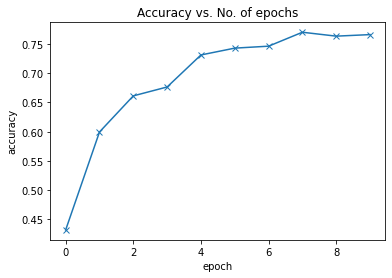

In [47]:
plot_accuracies(history)

In [48]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs No of epochs')

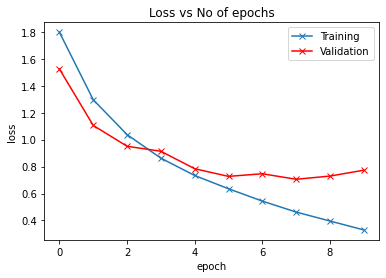

In [49]:
plot_losses(history)

Training error goes down and val error getting up after some time : overfitting

example:
![overfitting](https://mofanpy.com/static/results/torch/5-3-1.gif)

# Testing with Individual Images

In [50]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [51]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)      # convert to batch of 1
    yb = model(xb)                                # get predictions from model
    _, preds = torch.max(yb, dim=1)               # pick max probab
    return dataset.classes[preds[0].item()]       # retrive label

Label: airplane , Predicted: airplane


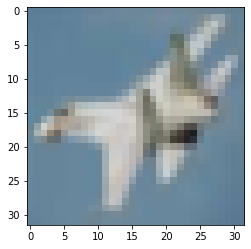

In [55]:
img, label = test_dataset[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


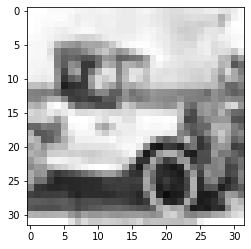

In [53]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: automobile


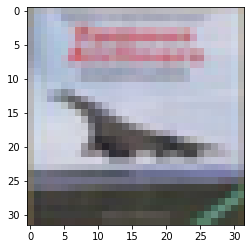

In [56]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


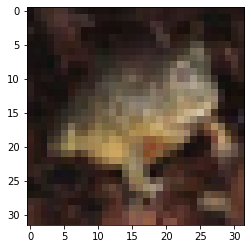

In [57]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [58]:
# overall result on test dataset

test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.7635641694068909, 'val_acc': 0.765625}

In [59]:
# saving weights of our model

torch.save(model.state_dict(), 'cifar10-cnn.pth')